In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df[col] = df[col].astype('category')
    return df

chunks = []
train_dataset = r"C:\Users\Naveen\Downloads\GUIDE_Train.csv.zip"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks
df.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Year,Month,DayOfWeek,Hour
0,3028,75,478,939479,4,0.006834,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.000000,0.608696
1,1813,0,211,160158,0,0.000000,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.166667,0.347826
2,1455,88,26726,1114326,58,0.097950,4,1,6,0,...,3586,5,66,242,1445,10630,1.0,0.454545,0.000000,0.043478
3,1731,0,375,169963,0,0.000000,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.000000,0.217391
4,4097,108,144844,118616,6,0.011390,5,2,5,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.500000,0.652174


In [10]:
# shape of the dataset
df.shape

(760627, 38)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760627 entries, 0 to 760626
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  760627 non-null  int32  
 1   OrgId               760627 non-null  int32  
 2   IncidentId          760627 non-null  int32  
 3   AlertId             760627 non-null  int32  
 4   DetectorId          760627 non-null  int32  
 5   AlertTitle          760627 non-null  float32
 6   Category            760627 non-null  int32  
 7   IncidentGrade       760627 non-null  int32  
 8   EntityType          760627 non-null  int32  
 9   EvidenceRole        760627 non-null  int32  
 10  DeviceId            760627 non-null  int32  
 11  Sha256              760627 non-null  int32  
 12  IpAddress           760627 non-null  int32  
 13  Url                 760627 non-null  int32  
 14  AccountSid          760627 non-null  int32  
 15  AccountUpn          760627 non-nul

In [12]:
# Check for missing values
df.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Year                  0
Month                 0
DayOfWeek             0
Hour                  0
dtype: int64

In [13]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
duplicate_count 

0

In [14]:
# Target variable distribution
df['IncidentGrade'].value_counts()

IncidentGrade
2    634706
1     67320
0     58601
Name: count, dtype: int64

In [15]:
#Data Cleaning and Preprocessing for Train Dataset

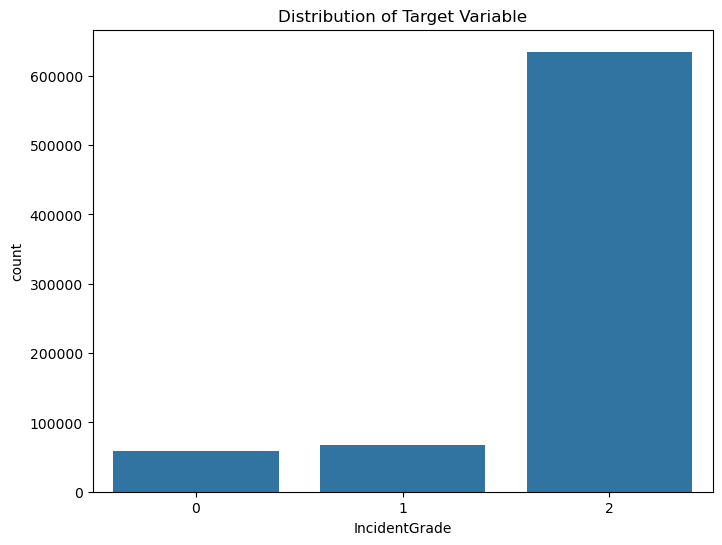

In [16]:
# plot Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped")

# Drop these columns
df.drop(columns=columns_to_drop, axis=1, inplace=True)

Columns with more than 50% missing values are dropped


In [18]:
# Impute missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object','category']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

In [19]:
# Impute missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32','float32']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

In [20]:
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR   
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Usage
df = outliers(df, iqr_multiplier=1.5) 

In [32]:
print(df.columns)


Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'DayOfWeek', 'Hour'],
      dtype='object')


In [38]:
# Check if 'timestamp' column exists
if 'timestamp' in df.columns:
    # Convert 'timestamp' column to datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Extract various components from the 'timestamp' column
    df['Year'] = df['timestamp'].dt.year
    df['Month'] = df['timestamp'].dt.month
    df['DayOfWeek'] = df['timestamp'].dt.dayofweek
    df['Hour'] = df['timestamp'].dt.hour

    # Drop the 'timestamp' column
    df.drop(columns=['timestamp'], inplace=True)
else:
    print("'timestamp' column is missing!")




'timestamp' column is missing!


In [40]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily', 'OSVersion', 'City','CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features 
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [42]:
# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

In [44]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [46]:
# Save
path = r"C:\Users\Naveen\Downloads\GUIDE_Train.csv.zip"
df.to_csv(path, index=False)
print("Data preprocessing complete and saved.")

Data preprocessing complete and saved.


In [47]:
#Data Exploration for Test Dataset

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df_1):
    # Downcast numerical columns
    for col in df_1.columns:
        col_type = df_1[col].dtypes
        if col_type == 'int64':
            df_1[col] = df_1[col].astype('int32')
        elif col_type == 'float64':
            df_1[col] = df_1[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df_1[col] = df_1[col].astype('category')
    return df_1

chunks = []
test_dataset = r"C:\Users\Naveen\Downloads\GUIDE_Test.csv (1).zip"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(test_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df_1 = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

df_1.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,3390,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,3658,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1715,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,5148,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,5019,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public



Shape of the dataset: (4147992, 46)
Column Names in the Dataset:
Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City', 'Usage'],
      dtype='object')

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtyp

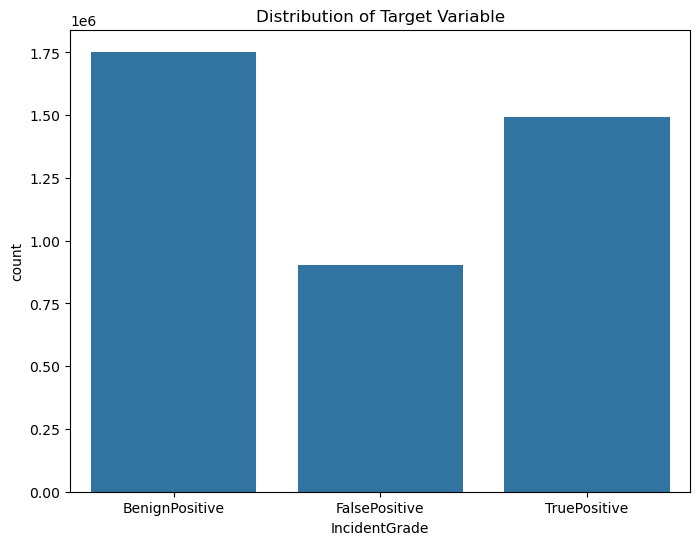

In [49]:
# Shape of the dataset
print("\nShape of the dataset:", df_1.shape)

# Column names
print("Column Names in the Dataset:")
print(df_1.columns)

print("\nDataset Information:")
print(df_1.info())

# Check for missing values
print("\nMissing values:")
print(df_1.isnull().sum())

# Check for duplicate rows
duplicate_count = df_1.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df_1['IncidentGrade'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=df_1['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [50]:
##Data Cleaning and Preprocessing for Test Dataset

In [51]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import zipfile

# Assuming df_1 is already loaded as your DataFrame

# Calculate the percentage of missing values for each column
missing_percentage = df_1.isnull().sum() / len(df_1) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped:")
print(columns_to_drop)

# Drop these columns
df_1.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns
numeric_columns = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
for col in numeric_columns:
    if df_1[col].isnull().any():
        median_val = df_1[col].median()
        df_1[col] = df_1[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

# Impute missing values for categorical columns
categorical_columns = df_1.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df_1[col].isnull().any():
        mode_val = df_1[col].mode()[0]
        df_1[col] = df_1[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

# Handling Outliers
def outliers(df_1, iqr_multiplier=1.5):
    numeric_features = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
            
        df_1 = df_1[(df_1[col] >= lower_bound) & (df_1[col] <= upper_bound)]
    return df_1

# Apply outlier handling
df_1 = outliers(df_1, iqr_multiplier=1.5)  # Adjusting the IQR multiplier if necessary

# Check for the existence of the 'Timestamp' column
if 'Timestamp' in df_1.columns:
    # Feature Engineering: Extracting datetime features
    df_1['Timestamp'] = pd.to_datetime(df_1['Timestamp'], errors='coerce')
    df_1['Year'] = df_1['Timestamp'].dt.year
    df_1['Month'] = df_1['Timestamp'].dt.month
    df_1['DayOfWeek'] = df_1['Timestamp'].dt.dayofweek
    df_1['Hour'] = df_1['Timestamp'].dt.hour

    # Drop the 'Timestamp' column after extracting features
    df_1.drop(columns=['Timestamp'], inplace=True)
else:
    print("The 'Timestamp' column is not present in the DataFrame.")

# Drop the 'Usage' column if it exists
df_1.drop(columns=['Usage'], inplace=True, errors='ignore')

# List of ID columns to exclude from scaling
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'City', 
              'CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features using MinMaxScaler
scaler = MinMaxScaler()
df_1[numeric_features.columns] = scaler.fit_transform(numeric_features)

# Encoding categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df_1.columns:
        df_1[col] = label_encoder.fit_transform(df_1[col].astype(str))  # Convert to string if necessary

# Remove duplicate rows
df_1.drop_duplicates(inplace=True)

# Saving the preprocessed DataFrame to a .zip file
zip_path = r"C:\Users\Naveen\Downloads\GUIDE_Test.csv.zip"

# Save DataFrame to a CSV inside a ZIP file
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    with zipf.open('GUIDE_Test.csv', 'w') as f:
        df_1.to_csv(f, index=False)

print("Data preprocessing complete and saved as a zip file.")


Columns with more than 50% missing values are dropped:
Index(['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict'],
      dtype='object')
Data preprocessing complete and saved as a zip file.


In [52]:
###Logistic Regression

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the dataset     
df = pd.read_csv(r"C:\Users\Naveen\Downloads\GUIDE_Train.csv.zip")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)  
y = df['IncidentGrade']  

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize logistic regression
logreg = LogisticRegression(C = 100, penalty = 'l1', solver='liblinear')

logreg = logreg.fit(X_train,y_train)

# Evaluate the model on validation data
y_pred = logreg.predict(X_val)

# Print results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       717
           1       0.77      0.17      0.28       281
           2       1.00      1.00      1.00    106914

    accuracy                           1.00    107912
   macro avg       0.87      0.66      0.70    107912
weighted avg       1.00      1.00      1.00    107912

Confusion Matrix:
[[   585      7    125]
 [    50     49    182]
 [    63      8 106843]]


In [54]:
#Decision Tree

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

# Load the dataset
df = pd.read_csv(r"C:\Users\Naveen\Downloads\GUIDE_Train.csv.zip")


# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Decision Tree Classifier
dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth= 20, min_samples_split=4, min_samples_leaf=1, 
                               max_features= 'log2', random_state=42)

# Evaluate the model on validation data
dtree = dtree.fit(X_train,y_train)

y_pred = dtree.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       717
           1       0.98      0.98      0.98       281
           2       1.00      1.00      1.00    106914

    accuracy                           1.00    107912
   macro avg       0.99      0.99      0.99    107912
weighted avg       1.00      1.00      1.00    107912

Confusion Matrix:
[[   714      3      0]
 [     1    276      4]
 [     0      2 106912]]


In [56]:

# Randam Forest Classifier

In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint

# Load dataset
df = pd.read_csv(r"C:\Users\Naveen\Downloads\GUIDE_Train.csv.zip")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth = 30, 
                            bootstrap = True, random_state=42)

rf = rf.fit(X_train,y_train)
# Evaluate the best model on validation data
y_pred = rf.predict(X_val)

# Print results
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       717
           1       1.00      0.98      0.99       281
           2       1.00      1.00      1.00    106914

    accuracy                           1.00    107912
   macro avg       1.00      0.99      1.00    107912
weighted avg       1.00      1.00      1.00    107912

Confusion Matrix:
[[   717      0      0]
 [     1    275      5]
 [     1      1 106912]]


In [58]:
#Gradient Boosting Machines - XGBoost

In [59]:
! pip install xgboost

In [60]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial

# Load dataset
df = pd.read_csv(r"C:\Users\Naveen\Downloads\GUIDE_Train.csv.zip")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize XGBoost Classifier
xgb = xgb.XGBClassifier(subsample = 0.8, n_estimators = 200, max_depth = 9, learning_rate = 0.2, colsample_bytree = 1.0,
                        random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb = xgb.fit(X_train,y_train)
# Evaluate the model on validation data
y_pred = xgb.predict(X_val)

# Print the evaluation results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

C:\Users\Naveen\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:23:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       717
           1       1.00      0.99      1.00       281
           2       1.00      1.00      1.00    106914

    accuracy                           1.00    107912
   macro avg       1.00      1.00      1.00    107912
weighted avg       1.00      1.00      1.00    107912

Confusion Matrix:
[[   717      0      0]
 [     0    279      2]
 [     0      0 106914]]


In [61]:
#Best Model selection

In [62]:
import pandas as pd

report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy':[0.91,0.98,0.99,0.99],
    'Macro-F1 Score':[ 0.76, 0.93, 0.98, 0.98],
    'Precision': [0.80,0.92,0.98,0.98],
    'Recall': [0.73,0.94,0.98 ,0.98]

}

# Convert to DataFrame
df = pd.DataFrame(report)

# Print comparison table
print("Comparison Table:")
print(df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = df.loc[df['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression      0.91            0.76       0.80    0.73
      Decision Tree      0.98            0.93       0.92    0.94
      Random Forest      0.99            0.98       0.98    0.98
            XGBoost      0.99            0.98       0.98    0.98

Best Model Based on Macro-F1 Score:
Model             Random Forest
Accuracy                   0.99
Macro-F1 Score             0.98
Precision                  0.98
Recall                     0.98
Name: 2, dtype: object


In [63]:
##Feature Importance and Error Analysis

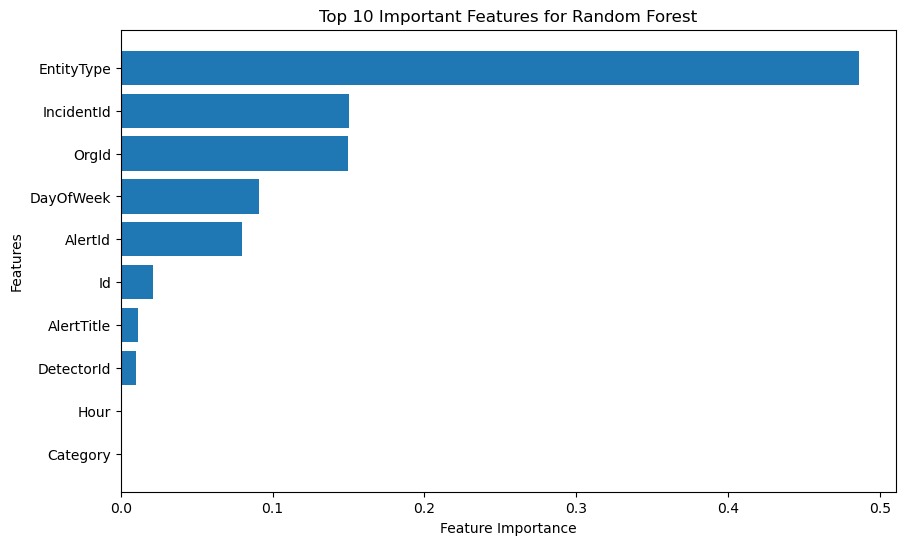

         Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  Category  \
285543  704    127         193  1043316           0         0.0         2   
384008  704    127         193  1043316           0         0.0         2   

        EntityType  EvidenceRole  DeviceId  ...  ResourceIdName  OSFamily  \
285543           1             0     98799  ...            3586         5   
384008           0             0     98799  ...            3586         5   

        OSVersion  CountryCode  State   City  Year  Month  DayOfWeek      Hour  
285543         66          242   1445  10630   0.0    1.0        0.5  0.913043  
384008         66          242   1445  10630   0.0    1.0        0.5  0.913043  

[2 rows x 37 columns]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       717
           1       1.00      0.99      1.00       281
           2       1.00      1.00      1.00    106914

    accuracy                 

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Get feature importances from the best Random Forest model
importances = rf.feature_importances_

features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importance for top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

# Identify misclassified samples
misclassified_idx = (y_val != y_pred)

# Extract the misclassified samples
misclassified_samples = X_val[misclassified_idx].copy()

# Display the first 5 misclassified samples
print(misclassified_samples.head(5))

# Evaluate the model's predictions
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

In [65]:
##Saving the Best Model

In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from joblib import dump
from imblearn.pipeline import Pipeline
from scipy.stats import randint

# Load dataset
df = pd.read_csv(r"C:\Users\Naveen\Downloads\GUIDE_Train.csv.zip")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data for class imbalance
smote = SMOTE(random_state=42)

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth = 30, 
                            bootstrap = True, random_state=42)

# Create the Pipeline
pipeline = Pipeline(steps=[
    ('smote', smote),
    ('classifier', rf)
])

# Fit the Pipeline
pipeline.fit(X_train, y_train)

# Evaluate the best model on validation data
y_pred = pipeline.predict(X_val)

# Print results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


# Save the best model to a pickle file
model_path = r"E:\Naveen\microsoft_classification"
dump(rf, model_path)
print(f"Model saved to {model_path}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       717
           1       1.00      0.99      0.99       281
           2       1.00      1.00      1.00    106914

    accuracy                           1.00    107912
   macro avg       1.00      1.00      1.00    107912
weighted avg       1.00      1.00      1.00    107912

Confusion Matrix:
[[   717      0      0]
 [     1    278      2]
 [     0      1 106913]]


PermissionError: [Errno 13] Permission denied: 'E:\\Naveen\\microsoft_classification'

In [ ]:
###Evaluation of Selected Random Forest Model on Test Data

In [28]:
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Load the saved Random Forest model
model_path = (r"E:\Naveen\microsoft_classification")

best_rf = load(model_path)

# Load the test dataset
test_dataset = r"C:\Users\Naveen\Downloads\GUIDE_Test.csv (1).zip"
test_df = pd.read_csv(test_data_path)

# Separate features and target from test data
X_test = test_df.drop('IncidentGrade', axis=1)  
y_test = test_df['IncidentGrade']

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Extract macro-F1 score, precision, and recall from the report
macro_f1 = report['macro avg']['f1-score']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']

print("\nMacro-F1 Score: {:.2f}".format(macro_f1))
print("Macro Precision: {:.2f}".format(macro_precision))
print("Macro Recall: {:.2f}".format(macro_recall))

# Confusion Matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))

PermissionError: [Errno 13] Permission denied: 'E:\\Naveen\\microsoft_classification'